In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.special import boxcox,inv_boxcox
import featexp as fp
from scipy.stats import zscore

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,QuantileTransformer,MinMaxScaler
from sklearn.model_selection import train_test_split,learning_curve,GridSearchCV,cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_log_error,mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Defining Necessary Functions

In [3]:
def l_curve(estimator):
    sns.set_style('darkgrid')
    plt.figure(figsize=(10,10))
    train_sizes=[40,100,500,1200,2000,3500,3850,4088]
    train_size,train_scores,test_scores=learning_curve(estimator=estimator,X=x_train.values,
                                                       y=y_train.values,train_sizes=train_sizes,
                                                      scoring='neg_mean_squared_log_error',cv=5,shuffle=True)
    train_scores=np.sqrt(-train_scores.mean(axis=1))
    test_scores=np.sqrt(-test_scores.mean(axis=1))
    plt.plot(train_size,train_scores,label='training Error',color='magenta')
    plt.plot(train_size,test_scores,label="Validation Error")
    plt.xlabel("training Size")
    plt.ylabel("RMSLE")
    plt.title("Learning Curve for {}".format(str(estimator)))
    
    

def cross_validation(estimator,data,label):
    accuracies=cross_val_score(estimator,X=data,y=np.exp(label),scoring='neg_mean_squared_log_error',cv=10)
    return (np.sqrt(-accuracies),np.sqrt(-accuracies).var())

def gridsearch(estimator,para,data,label):
    grid=GridSearchCV(estimator=estimator,param_grid=para,
                      scoring='neg_mean_squared_log_error',cv=5)
    grid.fit(data.values,np.exp(label))
    
    print(np.sqrt(-grid.best_score_),
          grid.best_params_)

In [4]:
os.chdir('/home/sadil/DS Projects/Used car')
os.listdir('/home/sadil/DS Projects/Used car')

['submission_xgboost_select.xlsx',
 'New_Price.csv',
 'new_test.xlsx',
 'submission_grad.xlsx',
 'Data_Test.xlsx',
 'Participants_Data_Used_Cars.zip',
 'datasets3.csv.zip',
 'submission_ada.xlsx',
 'train_new.xlsx',
 'submission_xgboost.xlsx',
 'test_new.xlsx',
 'Sample_submission.xlsx',
 'new_train.xlsx',
 'submission_forest.xlsx',
 'submission_lin.xlsx',
 'extra.csv',
 'Data_Train.xlsx']

In [5]:
train=pd.read_excel('new_train.xlsx')
test=pd.read_excel('new_test.xlsx')
new=pd.read_csv('New_Price.csv')

In [6]:
test['New_Price']=new['New_Price']

In [7]:
train.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Brand
0,India,Mumbai,10,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5,4.29,1.75,maruti
1,South Korea,Pune,5,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5,13.87,12.50,hyundai
2,Japan,Chennai,9,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5,8.61,4.50,honda
3,India,Chennai,8,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7,9.57,6.00,maruti
4,Germany,Coimbatore,7,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5,30.69,17.74,audi


In [8]:
test.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Brand
0,India,Delhi,6,40929,CNG,Manual,First,32.26 km/kg,998 CC,58.2 bhp,4,4.09,maruti
1,India,Coimbatore,7,54493,Petrol,Manual,Second,24.7 kmpl,796 CC,47.3 bhp,5,3.50,maruti
2,Japan,Mumbai,3,34000,Diesel,Manual,First,13.68 kmpl,2393 CC,147.8 bhp,7,20.97,toyota
3,Japan,Hyderabad,8,139000,Diesel,Manual,First,23.59 kmpl,1364 CC,67.04bhp,5,6.86,toyota
4,South Korea,Mumbai,6,29000,Petrol,Manual,First,18.5 kmpl,1197 CC,82.85 bhp,5,6.26,hyundai


In [9]:
#train.info(),test.info()

# <font color='red'>_Report of Analysis_<font>
> 
The no of missing values of New Price is too much.


In [10]:
train.describe()

,Year,Kilometers_Driven,Seats,New_Price,Price
count,6019.000000,6.019000e+03,6019.000000,6019.000000,6019.000000
mean,6.641801,5.873838e+04,5.277455,17.731901,9.479468
std,3.269742,9.126884e+04,0.806942,22.541020,11.187917
min,1.000000,1.710000e+02,0.000000,1.560000,0.440000
25%,4.000000,3.400000e+04,5.000000,6.410000,3.500000
50%,6.000000,5.300000e+04,5.000000,9.240000,5.640000
75%,9.000000,7.300000e+04,5.000000,17.720000,9.950000
max,22.000000,6.500000e+06,10.000000,374.000000,160.000000


In [11]:
train.corr()

,Year,Kilometers_Driven,Seats,New_Price,Price
Year,1.000000,0.173048,-0.014977,-0.038247,-0.305327
Kilometers_Driven,0.173048,1.000000,0.082895,0.014502,-0.011493
Seats,-0.014977,0.082895,1.000000,0.021042,0.052774
New_Price,-0.038247,0.014502,0.021042,1.000000,0.811074
Price,-0.305327,-0.011493,0.052774,0.811074,1.000000


#  <font color='magenta'>_Feature Modifying_<font>

In [2370]:
"""# Correcting Year
train['Year']=train['Year'].max()+1-train['Year']
test['Year']=test['Year'].max()+1-test['Year']"""

"# Correcting Year\ntrain['Year']=train['Year'].max()+1-train['Year']\ntest['Year']=test['Year'].max()+1-test['Year']"

In [2371]:
"""# Using The model of the car may lead to overfitting ,so try brand
company=[]
for i in range(len(train['Name'])):
    company.append(train['Name'][i].split(' ')[0])
train['Name']=company

company=[]
for i in range(len(test['Name'])):
    company.append(test['Name'][i].split(' ')[0])
test['Name']=company"""

"# Using The model of the car may lead to overfitting ,so try brand\ncompany=[]\nfor i in range(len(train['Name'])):\n    company.append(train['Name'][i].split(' ')[0])\ntrain['Name']=company\n\ncompany=[]\nfor i in range(len(test['Name'])):\n    company.append(test['Name'][i].split(' ')[0])\ntest['Name']=company"

In [2372]:
"""sns.set_style('darkgrid')
plt.figure(figsize=(13,8))
train['Name'].value_counts().plot(kind='bar',color='magenta')
plt.title('Country')"""

"sns.set_style('darkgrid')\nplt.figure(figsize=(13,8))\ntrain['Name'].value_counts().plot(kind='bar',color='magenta')\nplt.title('Country')"

In [2373]:
"""train['Price'][train['Name']=='Maruti'].plot(kind='box')
plt.title('Boxplot of Company Name')"""

"train['Price'][train['Name']=='Maruti'].plot(kind='box')\nplt.title('Boxplot of Company Name')"

Text(0.5, 0, 'Price')

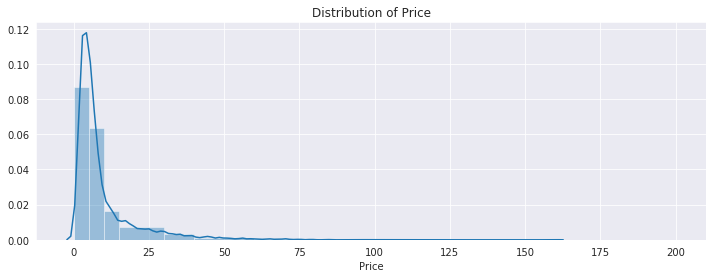

In [2374]:
plt.figure(figsize=(12,4))
sns.distplot(train['Price'],bins=[0,5,10,15,30,40,60,80,200])
plt.title('Distribution of Price')
plt.xlabel('Price')

In [2375]:
"""# Correcting New Price
train['New_Price']=train["New_Price"].apply(lambda x: str(x.lower()))
ranges=train['New_Price'].apply(lambda x:re.findall(r'[a-z]+',string=x)[0])

# There are many price written cr, need to convert
index=ranges[(ranges=='cr')|(ranges=='crore')|(ranges=='crores')].index
for i in range(6019):
    price[i]=re.findall(r'[0-9.]+',string=train['New_Price'].iloc[i])[0]
    price[i]=float(re.sub('^[.]',repl='',string=price[i]))
for i in index:
    price[i]=price[i]*100
train['New_Price']=price"""

'# Correcting New Price\ntrain[\'New_Price\']=train["New_Price"].apply(lambda x: str(x.lower()))\nranges=train[\'New_Price\'].apply(lambda x:re.findall(r\'[a-z]+\',string=x)[0])\n\n# There are many price written cr, need to convert\nindex=ranges[(ranges==\'cr\')|(ranges==\'crore\')|(ranges==\'crores\')].index\nfor i in range(6019):\n    price[i]=re.findall(r\'[0-9.]+\',string=train[\'New_Price\'].iloc[i])[0]\n    price[i]=float(re.sub(\'^[.]\',repl=\'\',string=price[i]))\nfor i in index:\n    price[i]=price[i]*100\ntrain[\'New_Price\']=price'

In [2376]:
"""# Correcting New Price
test['New_Price']=test["New_Price"].apply(lambda x: str(x.lower()))
ranges=test['New_Price'].apply(lambda x:re.findall(r'[a-z]+',string=x)[0])

# There are many price written cr, need to convert
index=ranges[(ranges=='cr')|(ranges=='crore')|(ranges=='crores')].index
for i in range(len(test)):
    price[i]=re.findall(r'[0-9.]+',string=test['New_Price'].iloc[i])[0]
    price[i]=float(re.sub('^[.]',repl='',string=price[i]))
for i in index:
    price[i]=price[i]*100
test['New_Price']=price"""

'# Correcting New Price\ntest[\'New_Price\']=test["New_Price"].apply(lambda x: str(x.lower()))\nranges=test[\'New_Price\'].apply(lambda x:re.findall(r\'[a-z]+\',string=x)[0])\n\n# There are many price written cr, need to convert\nindex=ranges[(ranges==\'cr\')|(ranges==\'crore\')|(ranges==\'crores\')].index\nfor i in range(len(test)):\n    price[i]=re.findall(r\'[0-9.]+\',string=test[\'New_Price\'].iloc[i])[0]\n    price[i]=float(re.sub(\'^[.]\',repl=\'\',string=price[i]))\nfor i in index:\n    price[i]=price[i]*100\ntest[\'New_Price\']=price'

Text(0.5, 1.0, 'Seats vs Price')

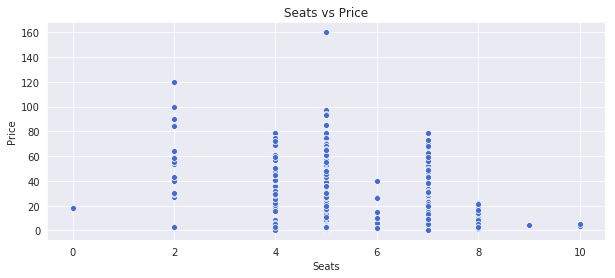

In [2377]:
plt.figure(figsize=(10,4))
sns.set_style('darkgrid')
sns.scatterplot(train['Seats'],train['Price'],color='royalblue')
plt.title("Seats vs Price")

Text(0.5, 1.0, 'Price of a New Car')

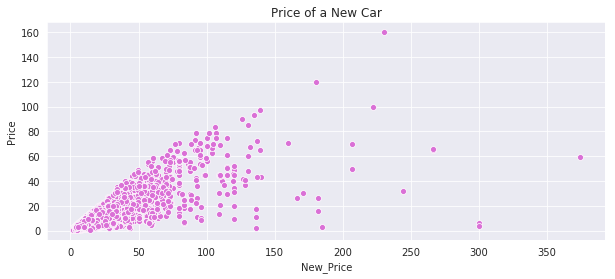

In [2378]:
plt.figure(figsize=(10,4))
sns.scatterplot(train['New_Price'],train['Price'],color='orchid')
plt.title("Price of a New Car")

Text(0.5, 0, 'Location')

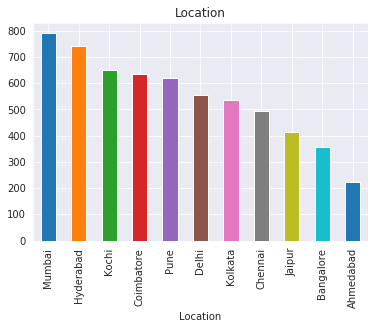

In [2379]:
train['Location'].value_counts().plot(kind='bar')
plt.title('Location')
plt.xlabel('Location')

Text(0.5, 1.0, 'Year vs Price')

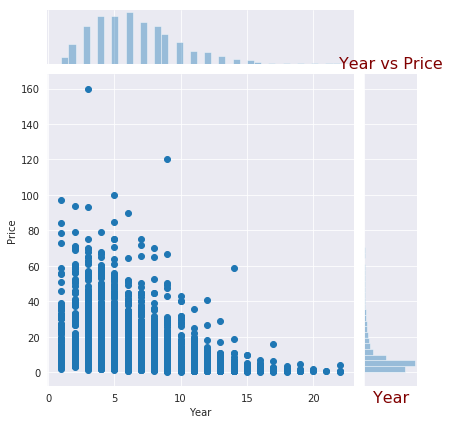

In [2380]:
sns.jointplot(x='Year',y="Price",data=train)
plt.xlabel('Year',color='maroon',fontsize=16)
plt.title('Year vs Price',color='maroon',fontsize=16)

Text(3.6750000000000114, 0.5, 'Price of Car')

<Figure size 720x720 with 0 Axes>

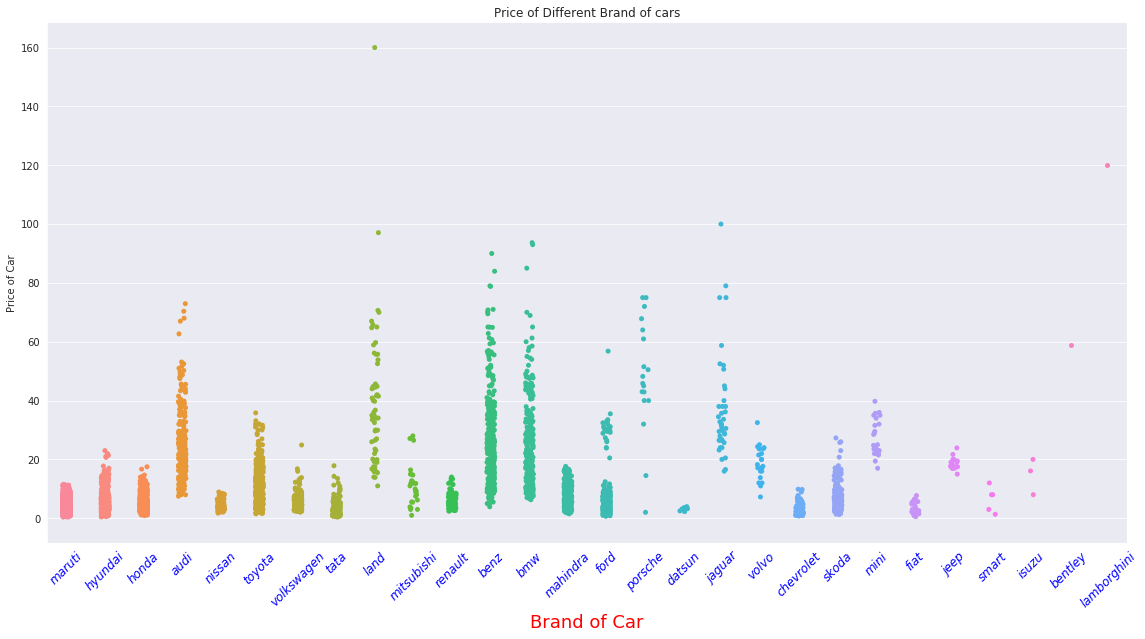

In [2381]:
plt.figure(figsize=(10,10))
sns.catplot(x='Brand',y='Price',data=train,height=8,aspect=2)
plt.title('Price of Different Brand of cars')
plt.xlabel('Brand of Car',color='red',fontsize=18)
plt.xticks(rotation=45,color='blue',fontsize=12,fontstyle='italic')
plt.ylabel('Price of Car')

Text(0, 0.5, 'Price of Car')

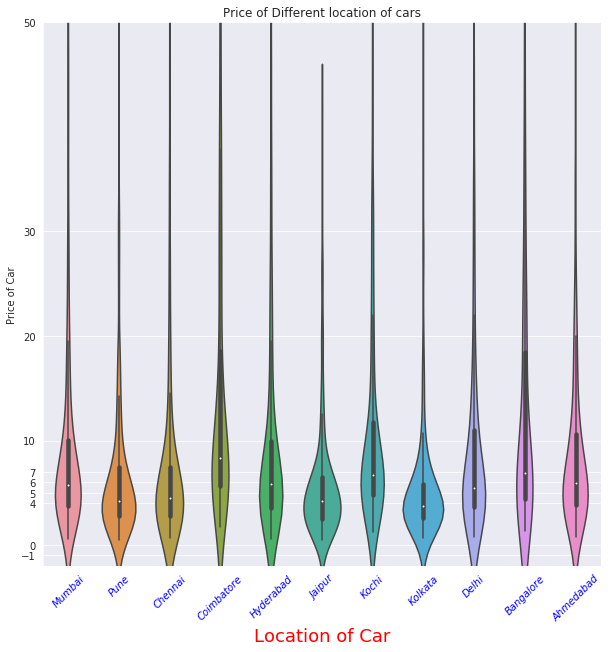

In [2382]:
plt.figure(figsize=(10,10))
sns.violinplot(train['Location'],train['Price'])
plt.title('Price of Different location of cars')
plt.xlabel('Location of Car',color='red',fontsize=18)
plt.xticks(rotation=45,color='blue',fontsize=10,fontstyle='italic')
plt.yticks([-1,0,4,5,6,7,10,20,30,50])
plt.ylim([-2,50])
plt.ylabel('Price of Car')

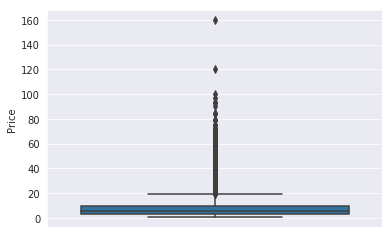

In [2383]:
sns.boxplot(train['Price'],orient='v')

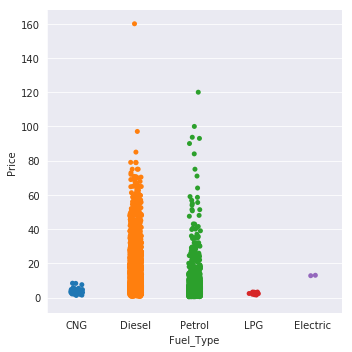

In [2384]:
sns.catplot(x='Fuel_Type',y='Price',data=train)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 <a list of 9 Text xticklabel objects>)

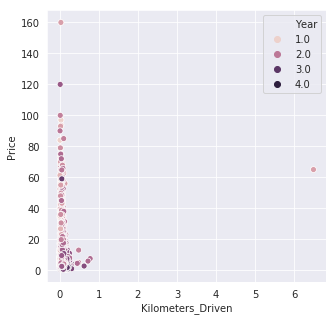

In [2385]:
plt.figure(figsize=(5,5))
sns.scatterplot(train['Kilometers_Driven']/(10e+5),train["Price"],hue=train['Year']**0.4)
plt.xticks()

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ]),
 <a list of 10 Text xticklabel objects>)

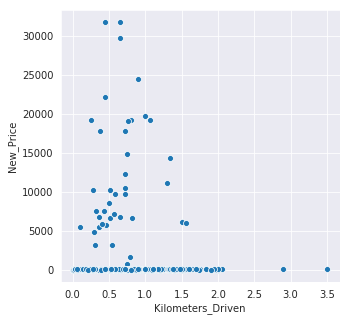

In [2386]:
plt.figure(figsize=(5,5))
sns.scatterplot(test['Kilometers_Driven']/(10e+4),test["New_Price"],palette=sns.color_palette("BuGn_r"))
plt.xticks()

>
A high Leverage Point

# Dataset for training

In [150]:
#Removing Leverage Point
train_copy=train[(train['Kilometers_Driven']!=train['Kilometers_Driven'].max()) & 
                 (train['Kilometers_Driven']>200)].copy()
#train_copy=train.copy()
test=pd.read_excel('new_test.xlsx')


#del test['Brand']
#del train_copy['Brand']
del train_copy['Name']
del test['Name']
del train_copy['Transmission']
del test['Transmission']
del train_copy['Seats']
del test['Seats']
#del train_copy['Fuel_Type']
#del test['Fuel_Type']

In [151]:
train_copy.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Owner_Type,Mileage,Engine,Power,New_Price,Price,Brand
0,Mumbai,10,72000,CNG,First,26.6 km/kg,998 CC,58.16 bhp,4.29,1.75,maruti
1,Pune,5,41000,Diesel,First,19.67 kmpl,1582 CC,126.2 bhp,13.87,12.50,hyundai
2,Chennai,9,46000,Petrol,First,18.2 kmpl,1199 CC,88.7 bhp,8.61,4.50,honda
3,Chennai,8,87000,Diesel,First,20.77 kmpl,1248 CC,88.76 bhp,9.57,6.00,maruti
4,Coimbatore,7,40670,Diesel,Second,15.2 kmpl,1968 CC,140.8 bhp,30.69,17.74,audi


In [152]:
test.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Owner_Type,Mileage,Engine,Power,New_Price,Brand
0,Delhi,6,40929,CNG,First,32.26 km/kg,998 CC,58.2 bhp,4.45,maruti
1,Coimbatore,7,54493,Petrol,Second,24.7 kmpl,796 CC,47.3 bhp,2.53,maruti
2,Mumbai,3,34000,Diesel,First,13.68 kmpl,2393 CC,147.8 bhp,25.27,toyota
3,Hyderabad,8,139000,Diesel,First,23.59 kmpl,1364 CC,67.04bhp,6.86,toyota
4,Mumbai,6,29000,Petrol,First,18.5 kmpl,1197 CC,82.85 bhp,6.26,hyundai


In [153]:
#test['Brand']=test['Brand'].replace({'hindustan':'bentley',
                                    #'opelcorsa':'bentley'})

In [154]:
"""location=pd.Series(list(train['Location'].unique()) +list(test['Location'].unique())).unique()
location={'Mumbai':29.75, 'Pune':28.14, 'Chennai':25.75, 'Coimbatore':24.75, 'Hyderabad':25.74, 'Jaipur':26.31,
       'Kochi':23.36, 'Kolkata':25.03, 'Delhi':28.20, 'Bangalore':28.43, 'Ahmedabad':25.32}
train_copy['Location']=train_copy['Location'].replace(location)
test['Location']=test['Location'].replace(location)"""

"location=pd.Series(list(train['Location'].unique()) +list(test['Location'].unique())).unique()\nlocation={'Mumbai':29.75, 'Pune':28.14, 'Chennai':25.75, 'Coimbatore':24.75, 'Hyderabad':25.74, 'Jaipur':26.31,\n       'Kochi':23.36, 'Kolkata':25.03, 'Delhi':28.20, 'Bangalore':28.43, 'Ahmedabad':25.32}\ntrain_copy['Location']=train_copy['Location'].replace(location)\ntest['Location']=test['Location'].replace(location)"

In [155]:
i='i'
f='f'
repl_train={'maruti':i, 'hyundai':i, 'honda':i, 'audi':f, 'nissan':f, 'toyota':f,
       'volkswagen':f, 'tata':i, 'land':f, 'mitsubishi':i, 'renault':f, 'benz':f,
       'bmw':f, 'mahindra':i, 'ford':f, 'porsche':f, 'datsun':f, 'jaguar':f, 'volvo':f,
       'chevrolet':f, 'skoda':f, 'mini':f, 'fiat':f, 'jeep':f, 'smart':f, 'isuzu':f,
       'bentley':f, 'lamborghini':f}
repl_test={'maruti':i, 'toyota':f, 'hyundai':i, 'mahindra':i, 'honda':i, 'audi':f,
       'nissan':f, 'bmw':f, 'ford':f, 'skoda':f, 'volkswagen':f, 'mitsubishi':f,
       'benz':f, 'tata':i, 'chevrolet':f, 'datsun':f, 'jaguar':f, 'fiat':f,
       'hindustan':i, 'renault':f, 'mini':f, 'bentley':f, 'land':f, 'volvo':f,
       'isuzu':f, 'jeep':f, 'porsche':f, 'opelcorsa':f}

br={'audi':7,'bentley':44,'benz':1,'bmw':4,'chevrolet':11,'datsun':101,
    'fiat':36,'ford':8,'hindustan':102,'honda':6,'hyundai':14,
    'isuzu':38,'jaguar':33,'jeep':40, 'lamborghini':52,'land':15,'mahindra':31,
    'maruti':22,'mini':32,'mitsubishi':47,'nissan':9,'opelcorsa':103,
    'porsche':5,'renault':12,'skoda':39,'smart':104,'tata':43,'toyota':2,'volkswagen':3,'volvo':105}

train_copy['Name']=train_copy['Brand'].replace(repl_train)
test['Name']=test['Brand'].replace(repl_test)

In [156]:
#train_copy['Seats']=train_copy['Seats'].replace({0:5})
#test['Seats']=test['Seats'].replace({0:5})
train_copy=train_copy[train_copy['Fuel_Type']!='Electric']
train_copy.index=[i for i in range(train_copy.shape[0])]


train_copy['New_Price']=train_copy['New_Price'].replace({300.0:7.62, 374.0:322.0})

"""extra=train_copy[(train['Year']>20)]
train_copy=pd.concat([train_copy,extra],axis=0)"""

"""extra=train_copy[train['Owner_Type']=='Fourth & Above']
train_copy=pd.concat([train_copy,extra],axis=0)"""

"extra=train_copy[train['Owner_Type']=='Fourth & Above']\ntrain_copy=pd.concat([train_copy,extra],axis=0)"

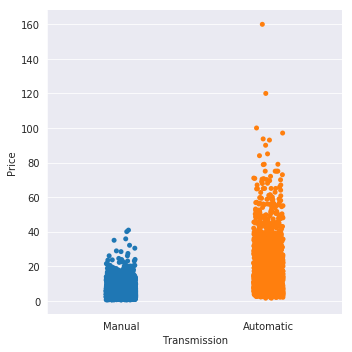

In [157]:
sns.set_style('darkgrid')
sns.catplot(x='Transmission',y='Price',data=train)

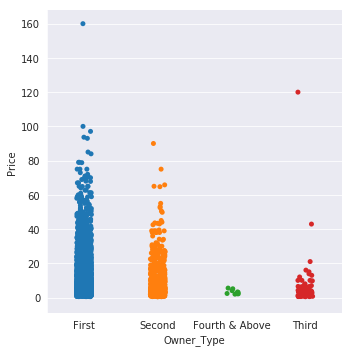

In [158]:
sns.catplot(x='Owner_Type',y='Price',data=train)

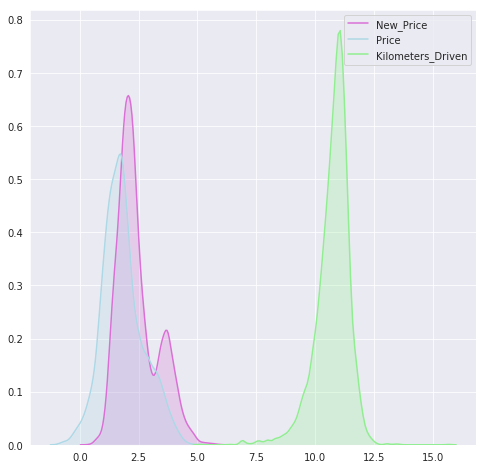

In [159]:
plt.figure(figsize=(8,8))
sns.kdeplot(np.log(train['New_Price']),shade=True,color='orchid')
sns.kdeplot(np.log(train['Price']),shade=True,color='lightblue')
sns.kdeplot(np.log(train['Kilometers_Driven']),shade=True,color='lightgreen')

### Converting Feature units to the same Units

In [160]:
#train_copy[train_copy['Mileage'].notnull()]['Mileage'].apply(lambda x: x.split(' ')[1])

In [161]:
train_copy['Mileage']=train_copy['Mileage'].fillna('-1 kmpl')
train_copy['Mileage']=train_copy["Mileage"].apply(lambda x: float(re.findall(r'[0-9.]+[0-9]',string=x)[0]))
train_copy['Mileage']=train_copy["Mileage"].replace({-1:train_copy["Mileage"].mean()})

test['Mileage']=test['Mileage'].fillna('-1 kmpl')
test['Mileage']=test["Mileage"].apply(lambda x: float(re.findall(r'[0-9.]+[0-9]',string=x)[0]))
test['Mileage']=test["Mileage"].replace({-1:test["Mileage"].mean()})

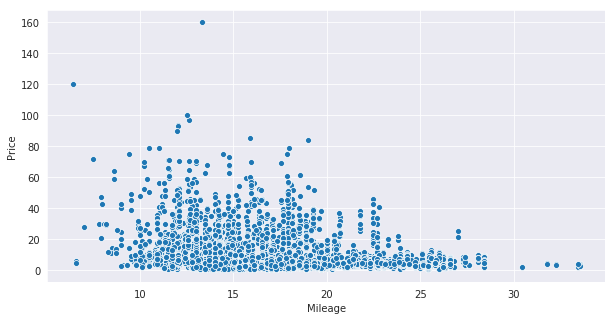

In [162]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,5))
sns.scatterplot(train_copy["Mileage"],train_copy['Price'])

### _Changing Engine and Power Feature_

In [163]:
train_copy['Engine']=train_copy['Engine'].apply(lambda x: float(re.findall(r'[0-9.]+[0-9]',string=str(x))[0]))
train_copy['Power']=train_copy['Power'].apply(lambda x: float(re.findall(r'[0-9.]+[0-9]',string=x)[0]))

train_copy['Engine']=train_copy['Engine'].replace({-1,train_copy['Engine'].mean()})
train_copy['Power']=train_copy['Power'].replace([-1,train_copy['Power'].mean()])

test['Engine']=test['Engine'].apply(lambda x: float(re.findall(r'[0-9.]+[0-9]',string=str(x))[0]))
test['Power']=test['Power'].apply(lambda x: float(re.findall(r'[0-9.]+[0-9]',string=str(x))[0]))
#test['Engine']=test['Engine'].replace({-1,test['Engine'].mean()})
#test['Power']=test['Power'].replace([-1,test['Power'].mean()])

Text(0.5, 0, 'Power')

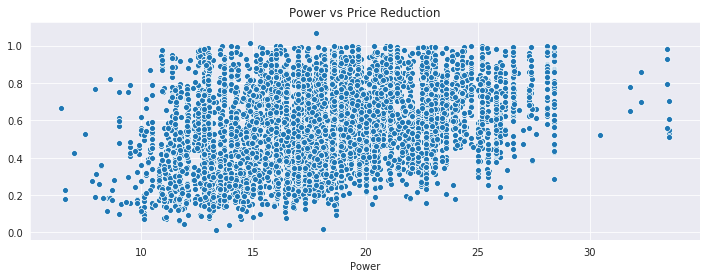

In [164]:
plt.figure(figsize=(12,4))
sns.scatterplot(train_copy['Mileage'],train_copy['Price']/train_copy['New_Price'])
plt.title('Power vs Price Reduction')
plt.xlabel('Power')

In [165]:
train_copy.corr()

,Year,Kilometers_Driven,Mileage,Engine,Power,New_Price,Price
Year,1.000000,0.448346,-0.296021,0.051211,-0.029263,-0.046189,-0.305326
Kilometers_Driven,0.448346,1.000000,-0.139509,0.153740,-0.001906,-0.036408,-0.168445
Mileage,-0.296021,-0.139509,1.000000,-0.638936,-0.542743,-0.408643,-0.333849
Engine,0.051211,0.153740,-0.638936,1.000000,0.867665,0.745441,0.659072
Power,-0.029263,-0.001906,-0.542743,0.867665,1.000000,0.870894,0.771351
New_Price,-0.046189,-0.036408,-0.408643,0.745441,0.870894,1.000000,0.838146
Price,-0.305326,-0.168445,-0.333849,0.659072,0.771351,0.838146,1.000000


> <font color='red'>The minimum value for Engine is quite low compared to other values.
    Let's Check the datapoint<font>

# Feature Transformation

In [166]:
train_copy['Kilometers_Driven']=train_copy['Kilometers_Driven']/train_copy['Year']
test['Kilometers_Driven']=test['Kilometers_Driven']/test['Year']

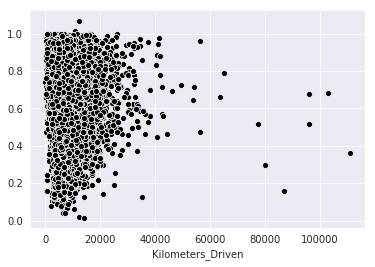

In [167]:
sns.scatterplot(train_copy['Kilometers_Driven'],train_copy['Price']/train_copy['New_Price'],color='black')

# Checking skewness and kurtosis

In [168]:
sns.set_style('darkgrid')
"""skew=[]
name=['New_Price','Price','Mileage','Power','Engine','Kilometers_Driven']
skew.append(train_copy['New_Price'].skew())
skew.append(train_copy['Price'].skew())
skew.append(train_copy['Mileage'].skew())
skew.append(train_copy['Power'].skew())
skew.append(train_copy['Engine'].skew())
skew.append(train_copy['Kilometers_Driven'].skew())
sns.scatterplot(y=skew,x=name)
plt.annotate(skew[5],xy=(name[5],skew[5]))
plt.title('Skewness of Various Columns')"""

"skew=[]\nname=['New_Price','Price','Mileage','Power','Engine','Kilometers_Driven']\nskew.append(train_copy['New_Price'].skew())\nskew.append(train_copy['Price'].skew())\nskew.append(train_copy['Mileage'].skew())\nskew.append(train_copy['Power'].skew())\nskew.append(train_copy['Engine'].skew())\nskew.append(train_copy['Kilometers_Driven'].skew())\nsns.scatterplot(y=skew,x=name)\nplt.annotate(skew[5],xy=(name[5],skew[5]))\nplt.title('Skewness of Various Columns')"

In [169]:
"""sns.set_style('darkgrid')
skew=[]
name=['New_Price','Price','Mileage','Power','Engine','Kilometers_Driven']
skew.append(np.log(train_copy['New_Price']).skew())
skew.append(np.log(train_copy['Price']).skew())
skew.append(np.log(train_copy['Mileage']).skew())
skew.append(np.log(train_copy['Power']).skew())
skew.append(np.log(train_copy['Engine']).skew())
skew.append(np.log(train_copy['Kilometers_Driven']).skew())
sns.scatterplot(y=skew,x=name)
plt.annotate(skew[5],xy=(name[5],skew[5]))
plt.title('Skewness of Various Columns after Log Transformation')"""

"sns.set_style('darkgrid')\nskew=[]\nname=['New_Price','Price','Mileage','Power','Engine','Kilometers_Driven']\nskew.append(np.log(train_copy['New_Price']).skew())\nskew.append(np.log(train_copy['Price']).skew())\nskew.append(np.log(train_copy['Mileage']).skew())\nskew.append(np.log(train_copy['Power']).skew())\nskew.append(np.log(train_copy['Engine']).skew())\nskew.append(np.log(train_copy['Kilometers_Driven']).skew())\nsns.scatterplot(y=skew,x=name)\nplt.annotate(skew[5],xy=(name[5],skew[5]))\nplt.title('Skewness of Various Columns after Log Transformation')"

In [170]:
qt=QuantileTransformer(output_distribution='normal')

In [171]:
col=['New_Price','Mileage','Engine','Power','Kilometers_Driven','Year']
train_copy[col]=qt.fit_transform(train_copy[col])
train_copy['Price']=np.log(train_copy['Price'])
test[col]=qt.fit_transform(test[col])

In [172]:
"""train_copy['New_Price']=np.log(train_copy['New_Price'])
train_copy['Mileage']=np.log(train_copy['Mileage'])
train_copy['Engine']=np.log(train_copy['Engine'])
train_copy['Power']=np.log(train_copy['Power'])
train_copy['Kilometers_Driven']=np.log(train_copy['Kilometers_Driven'])
train_copy['Year']=np.log(train_copy['Year'])
train_copy['Price']=np.log(train_copy['Price'])"""

"train_copy['New_Price']=np.log(train_copy['New_Price'])\ntrain_copy['Mileage']=np.log(train_copy['Mileage'])\ntrain_copy['Engine']=np.log(train_copy['Engine'])\ntrain_copy['Power']=np.log(train_copy['Power'])\ntrain_copy['Kilometers_Driven']=np.log(train_copy['Kilometers_Driven'])\ntrain_copy['Year']=np.log(train_copy['Year'])\ntrain_copy['Price']=np.log(train_copy['Price'])"

In [173]:
"""test['New_Price']=np.log(test['New_Price'])
test['Mileage']=np.log(test['Mileage'])
test['Engine']=np.log(test['Engine'])
test['Power']=np.log(test['Power'])
test['Kilometers_Driven']=np.log(test['Kilometers_Driven'])
test['Year']=np.log(test['Year'])"""

"test['New_Price']=np.log(test['New_Price'])\ntest['Mileage']=np.log(test['Mileage'])\ntest['Engine']=np.log(test['Engine'])\ntest['Power']=np.log(test['Power'])\ntest['Kilometers_Driven']=np.log(test['Kilometers_Driven'])\ntest['Year']=np.log(test['Year'])"

# _Creating DataSet for Training and Validation_


### Label Encoding

In [174]:
y=train_copy.pop('Price')
data=train_copy
"""train_copy=train_copy.loc[:,['Location','Year','Brand','Fuel_Type',
                             'Owner_Type', 'Mileage', 'Engine', 'Power',
                             'New_Price']]

test=test.loc[:,['Location','Year','Fuel_Type',
                             'Owner_Type', 'Mileage', 'Engine', 'Power',
                             'New_Price','Brand']]"""

"train_copy=train_copy.loc[:,['Location','Year','Brand','Fuel_Type',\n                             'Owner_Type', 'Mileage', 'Engine', 'Power',\n                             'New_Price']]\n\ntest=test.loc[:,['Location','Year','Fuel_Type',\n                             'Owner_Type', 'Mileage', 'Engine', 'Power',\n                             'New_Price','Brand']]"

In [175]:
le=LabelEncoder()

In [176]:
train_copy['Name']=le.fit_transform(train_copy['Name'])
train_copy['Brand']=le.fit_transform(train_copy['Brand'])
train_copy['Location']=le.fit_transform(train_copy['Location'])
train_copy['Fuel_Type']=le.fit_transform(train_copy['Fuel_Type'])
#train_copy['Owner_Type']=le.fit_transform(train_copy['Owner_Type'])
#train_copy['Transmission']=le.fit_transform(train_copy['Transmission'])

In [177]:
test['Name']=le.fit_transform(test['Name'])
test['Brand']=le.fit_transform(test['Brand'])
test['Location']=le.fit_transform(test['Location'])
test['Fuel_Type']=le.fit_transform(test['Fuel_Type'])
#test['Owner_Type']=le.fit_transform(test['Owner_Type'])
#test['Transmission']=le.fit_transform(test['Transmission'])

In [178]:
train_copy['Owner_Type']=train_copy['Owner_Type'].replace({'First':1,
                                                          'Second':2,
                                                          'Third':3,
                                                          'Fourth & Above':4})
test['Owner_Type']=test['Owner_Type'].replace({'First':1,
                                                          'Second':2,
                                                          'Third':3,
                                                          'Fourth & Above':4})
train_copy['Owner_Type']=qt.fit_transform(train_copy['Owner_Type'].values.reshape(-1,1)).squeeze()
test['Owner_Type']=qt.fit_transform(test['Owner_Type'].values.reshape(-1,1)).squeeze()

In [179]:
data=train_copy.copy()

In [180]:
#train_copy

### Making Dummy variable for Categorical Variables

In [181]:
sc=StandardScaler()
fuel_type=pd.get_dummies(train_copy['Fuel_Type'],drop_first=True)
fuel_type.index=[i for i in range(train_copy.shape[0])]

"""owner=pd.get_dummies(train_copy['Owner_Type'],drop_first=True)
owner.index=[i for i in range(train_copy.shape[0])]"""

location=pd.get_dummies(train_copy['Location'],drop_first=True)
location.index=[i for i in range(train_copy.shape[0])]

"""km=pd.get_dummies(train_copy['Kilometers_Driven'],drop_first=True)
km.index=[i for i in range(train_copy.shape[0])]
"""
brand=pd.get_dummies(train_copy['Brand'],drop_first=True)
brand.index=[i for i in range(train_copy.shape[0])]

"""trans=pd.get_dummies(train_copy['Transmission'],drop_first=True)
trans.index=[i for i in range(train_copy.shape[0])]
"""


train_copy=train_copy.drop(['Fuel_Type','Location','Brand'],axis=1)
train_copy.index=[i for i in range(train_copy.shape[0])]

#train_copy=pd.DataFrame(sc.fit_transform(train_copy))
train_copy=pd.concat([fuel_type,location,brand,train_copy],axis=1,ignore_index=True)
#train_copy.index=[i for i in range(train_copy.shape[0])]

In [182]:
fuel_type=pd.get_dummies(test['Fuel_Type'],drop_first=True)

#owner=pd.get_dummies(test['Owner_Type'],drop_first=True)

location=pd.get_dummies(test['Location'],drop_first=True)

#km=pd.get_dummies(test['Kilometers_Driven'],drop_first=True)


brand=pd.get_dummies(test['Brand'],drop_first=True)
#trans=pd.get_dummies(test['Transmission'],drop_first=True)

test=test.drop(['Fuel_Type','Location','Brand'],axis=1)

#test=pd.DataFrame(sc.fit_transform(test))
test=pd.concat([fuel_type,location,brand,test],axis=1,ignore_index=True)

## Spliting Dataset

In [183]:
x_train,x_test,y_train,y_test=train_test_split(train_copy,y,test_size=0.15,random_state=37)

# Random Forest

In [184]:
"""parameter=[{'n_estimators':[400],'max_depth':[20],'max_features':['auto'],'min_samples_split':[2],
           'min_impurity_split':[0.0001]}]
%time gridsearch(forest,parameter,x_train,y_train)"""

"parameter=[{'n_estimators':[400],'max_depth':[20],'max_features':['auto'],'min_samples_split':[2],\n           'min_impurity_split':[0.0001]}]\n%time gridsearch(forest,parameter,x_train,y_train)"

In [185]:
forest=RandomForestRegressor(n_estimators=500,max_depth=17,max_features='auto',
                             min_impurity_decrease=0.000001,min_samples_split=4,
                             n_jobs=-1)
forest.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=1e-06, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [186]:
np.sqrt(mean_squared_log_error(np.exp(y_test),np.exp(forest.predict(x_test))))

0.1820462369599166

In [187]:
np.sqrt(mean_squared_log_error(np.exp(y_train),np.exp(forest.predict(x_train))))

0.0667647850434453

In [188]:
mean_squared_error(np.exp(y_train.values),np.exp(forest.predict(x_train.values))),mean_squared_error(np.exp(y_test.values),np.exp(forest.predict(x_test.values)))

(1.9674163733850656, 18.91654163876085)

In [189]:
np.exp(forest.predict(test))

array([ 3.03304844,  2.51545638, 20.92562558, ...,  3.22277014,
        4.73419343, 22.75492153])

In [407]:
submission=pd.DataFrame({'Price':np.exp(forest.predict(test))})
submission.to_excel('submission_forest.xlsx',index=False)

In [2077]:
%time cross_validation(forest,x_train,y_train)

CPU times: user 6.94 s, sys: 1.16 s, total: 8.1 s
Wall time: 26.9 s


(array([0.14901073, 0.19014713, 0.15409612, 0.16791413, 0.15916026,
        0.15143695, 0.17768855, 0.1445964 , 0.1542329 , 0.15312514]),
 0.0001831614456662901)

In [112]:
r2_score(np.exp(y_test),np.exp(forest.predict(x_test)))

0.8810424346441976

In [113]:
np.sqrt(mean_squared_log_error(np.exp(y),np.exp(forest.predict(train_copy))))

0.0939332291830026

In [114]:
np.sort(forest.feature_importances_)

array([1.74387470e-06, 3.96093833e-06, 7.65054493e-06, 1.18342590e-05,
       1.32486685e-05, 1.75482450e-05, 1.89145496e-05, 2.02936265e-05,
       2.08599472e-05, 2.88380532e-05, 3.89043575e-05, 5.50333492e-05,
       9.24692903e-05, 1.48227445e-04, 2.48407480e-04, 2.75655515e-04,
       3.32720470e-04, 3.56500546e-04, 3.76926350e-04, 4.52159236e-04,
       5.29989538e-04, 6.24252544e-04, 6.42666009e-04, 6.59454895e-04,
       6.74324121e-04, 6.76382466e-04, 6.80984344e-04, 7.36836674e-04,
       7.43189126e-04, 7.77190349e-04, 7.86599619e-04, 9.89743869e-04,
       1.01815415e-03, 1.30455556e-03, 1.50132328e-03, 1.59087820e-03,
       1.72315766e-03, 1.72417157e-03, 1.75660513e-03, 2.68863376e-03,
       2.82525250e-03, 3.78783266e-03, 7.25378559e-03, 9.34209405e-03,
       1.05025976e-02, 1.08341538e-02, 1.97259875e-01, 7.33843419e-01])

In [1019]:
threshold=np.sort(forest.feature_importances_)[1]
cross_score=[]
test_score=[]
train_score=[]

    # Selecting Features from threshold
selection=SelectFromModel(forest,threshold=threshold,prefit=True)
select_x_train=selection.transform(x_train)
select_x_test=selection.transform(x_test)
select_test=selection.transform(test)
    # Training Model
forest_select=RandomForestRegressor(n_estimators=750,max_depth=20,
                             n_jobs=-1,oob_score=True,max_features='sqrt')
forest_select.fit(select_x_train,y_train)
    
test_score=np.sqrt(mean_squared_log_error(np.exp(y_test.values),np.exp(forest_select.predict(select_x_test))))
train_score=np.sqrt(mean_squared_log_error(np.exp(y_train.values),np.exp(forest_select.predict(select_x_train))))

test_score,train_score,cross_validation(xg_select,select_x_train)[1]

#plt.bar(range(len(threshold)),[test_score,train_score,cross_score])

NameError: name 'select' is not defined

In [ ]:
parameters=[{'n_estimators':[250,240]}]
gridsearch(forest,parameters)

# _XGBoost_

In [ ]:
"""booster='gbtree',
                base_score=0.65,colsample_bylevel=0.71,colsample_bynode=0.71,
                colsample_bytree=0.71,
                learning_rate=0.07,max_depth=7,n_jobs=-1,n_estimators=800,reg_alpha=0.7,
                reg_lambda=0.8,subsample=0.83,objective='reg:squarederror'"""

"""booster='gbtree',colsample_bytree=0.61,colsample_bylevel=0.6,base_score=0.45,learning_rate=0.067,max_depth=10,n_jobs=-1,n_estimators=450,reg_alpha=0.5,
                    reg_lambda=7,subsample=0.965"""

"""booster='gbtree',colsample_bytree=0.61,colsample_bylevel=0.6,base_score=0.45,
                     learning_rate=0.067,max_depth=10,n_jobs=-1,n_estimators=450,reg_alpha=0.5,
                    reg_lambda=0.7,subsample=0.965""" 0.9367

"""booster='gbtree',
                     colsample_bytree=0.71,colsample_bylevel=0.71,base_score=0.65,
                     learning_rate=0.067,max_depth=9,n_jobs=-1,n_estimators=500,reg_alpha=0.5,
                    reg_lambda=7,subsample=0.98"""

In [520]:
parameter=[{'booster':['gbtree'],'colsample_bytree':[0.8],'colsample_bylevel':[0.7],
            'base_score':[0.06],'learning_rate':[0.06,0.067],
            'max_depth':[9],'reg_alpha':[0.5],'subsample':[0.83],'n_estimators':[550],
                    'reg_lambda':[0.7],"colsample_bynode":[0.8],'n_jobs':[-1],
           'objective':['reg:squarederror']}]
#0.14116918060152278
%time gridsearch(xg,parameter,x_train,y_train)

0.14271858553241795 {'base_score': 0.06, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.8, 'colsample_bytree': 0.8, 'learning_rate': 0.067, 'max_depth': 9, 'n_estimators': 650, 'n_jobs': -1, 'objective': 'reg:squarederror', 'reg_alpha': 0.5, 'reg_lambda': 0.7, 'subsample': 0.83}
CPU times: user 2min 42s, sys: 489 ms, total: 2min 42s
Wall time: 20.5 s


In [1237]:
eval_set = [(x_train.values, y_train.values), (x_test.values, y_test.values)]
eval_metric = ["rmse","error"]

In [497]:
xg=XGBRegressor(booster='gbtree',
                base_score=0.06,colsample_bylevel=0.71,colsample_bynode=0.8,
                colsample_bytree=0.8,
                learning_rate=0.06,max_depth=10,n_jobs=-1,n_estimators=650,reg_alpha=0.5,
                reg_lambda=0.8,subsample=0.83,objective='reg:squarederror')

%time xg.fit(x_train.values,y_train.values)

CPU times: user 20.6 s, sys: 46.5 ms, total: 20.7 s
Wall time: 2.65 s


XGBRegressor(base_score=0.06, booster='gbtree', colsample_bylevel=0.71,
             colsample_bynode=0.8, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.06, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=650,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.5, reg_lambda=0.8, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.83, verbosity=1)

In [498]:
np.sqrt(mean_squared_log_error(np.exp(y_test.values),np.exp(xg.predict(x_test.values))))

0.1685849564916544

In [499]:
np.sqrt(mean_squared_log_error(np.exp(y_train.values),np.exp(xg.predict(x_train.values))))

0.0409509151282692

In [500]:
mean_squared_error(np.exp(y_train.values),np.exp(xg.predict(x_train.values))),mean_squared_error(np.exp(y_test.values),np.exp(xg.predict(x_test.values)))

(0.5740264122999008, 19.451761156915968)

In [501]:
pd.DataFrame({'act':np.exp(y),'pred':np.exp(xg.predict(train_copy.values))}).head()

,act,pred
0,1.75,1.879642
1,12.50,12.123905
2,4.50,4.430406
3,6.00,5.956221
4,17.74,18.082901


In [502]:
xg.get_booster().best_ntree_limit

650

In [503]:
#0.00010123939399463932
%time cross_validation(xg,x_train,y_train)

CPU times: user 3min 18s, sys: 518 ms, total: 3min 19s
Wall time: 25.4 s


(array([0.13293814, 0.16630775, 0.13770152, 0.15288042, 0.13994228,
        0.12683203, 0.1533802 , 0.13026198, 0.1339801 , 0.13931263]),
 0.00013787993780393183)

In [504]:
np.sqrt(mean_squared_log_error(np.exp(y.values),np.exp(xg.predict(train_copy.values))))

0.07544467256071233

In [505]:
r2_score(np.exp(y),np.exp(xg.predict(train_copy.values,ntree_limit=400)))

0.9708588711190905

In [513]:
np.exp(xg.predict(test.values)),np.exp(xg_select.predict(select_test))

(array([ 3.0264907,  2.8465354, 21.14164  , ...,  3.119951 ,  4.6004457,
        18.501047 ], dtype=float32),
 array([ 3.0829241,  2.728236 , 22.354177 , ...,  3.0681033,  4.726815 ,
        17.073866 ], dtype=float32))

In [507]:
submission=pd.DataFrame({'Price':np.exp(xg.predict(test.values))})
submission.to_excel('submission_xgboost.xlsx',index=False)

In [514]:
submission=pd.DataFrame({'Price':np.exp(xg_select.predict(select_test))})
submission.to_excel('submission_xgboost_select.xlsx',index=False)

In [419]:
# %time l_curve(xg)

In [1815]:
"""parameters=[{'learning_rate':[0.1,0.2,0.09],
            'gamma':[0.1,0.2,0.3],
            'min_child_weight':[1,2,3],
            'base_score':[0.5,0.6]}]
gridsearch(xgboost,parameters)"""

"parameters=[{'learning_rate':[0.1,0.2,0.09],\n            'gamma':[0.1,0.2,0.3],\n            'min_child_weight':[1,2,3],\n            'base_score':[0.5,0.6]}]\ngridsearch(xgboost,parameters)"

<BarContainer object of 48 artists>

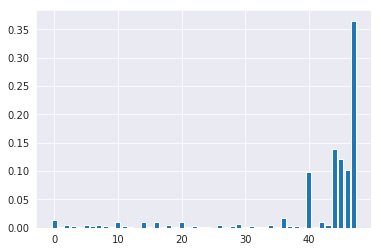

In [508]:
plt.bar(range(len(xg.feature_importances_)),xg.feature_importances_)

In [509]:
np.sort(xg.feature_importances_)

array([0.00000000e+00, 2.80392240e-04, 6.56056858e-04, 7.35757698e-04,
       7.51744898e-04, 7.76472851e-04, 8.64447909e-04, 9.68580018e-04,
       1.12277013e-03, 1.15854503e-03, 1.28077494e-03, 1.30560121e-03,
       1.34025875e-03, 1.44017406e-03, 1.54134724e-03, 1.86028844e-03,
       1.93368504e-03, 2.18115118e-03, 2.27491953e-03, 2.48822453e-03,
       2.74530170e-03, 2.84735626e-03, 3.14092916e-03, 3.14717973e-03,
       3.38027230e-03, 3.44599597e-03, 3.64487967e-03, 3.64708295e-03,
       4.21684841e-03, 4.33918927e-03, 4.34431573e-03, 4.74007614e-03,
       5.04038297e-03, 5.08383615e-03, 5.77373151e-03, 6.08525937e-03,
       9.70712956e-03, 1.02366684e-02, 1.09426156e-02, 1.09951068e-02,
       1.10983634e-02, 1.44142322e-02, 1.79809835e-02, 9.78374779e-02,
       1.01829275e-01, 1.20589525e-01, 1.38715059e-01, 3.65069747e-01],
      dtype=float32)

In [512]:
threshold=np.sort(xg.feature_importances_)[1]
test_score=[]
train_score=[]

    # Selecting Features from threshold
selection=SelectFromModel(xg,threshold=threshold,prefit=True)
select_x_train=selection.transform(x_train)
select_x_test=selection.transform(x_test)
select_test=selection.transform(test)
select_train=selection.transform(train_copy)
    # Training Model
xg_select=XGBRegressor(booster='gbtree',
                base_score=0.06,colsample_bylevel=0.71,colsample_bynode=0.8,
                colsample_bytree=0.8,
                learning_rate=0.06,max_depth=10,n_jobs=-1,n_estimators=650,reg_alpha=0.5,
                reg_lambda=0.8,subsample=0.83,objective='reg:squarederror')
xg_select.fit(select_x_train,y_train)
    
test_score=np.sqrt(mean_squared_log_error(np.exp(y_test.values),np.exp(xg_select.predict(select_x_test))))
train_score=np.sqrt(mean_squared_log_error(np.exp(y_train.values),np.exp(xg_select.predict(select_x_train))))

print("test:" ,test_score,"train",train_score,"cross_validation",
            cross_validation(xg_select,select_x_train,y_train)[1],
       "mse",mean_squared_error(np.exp(y_test.values),np.exp(xg_select.predict(select_x_test))),
       "rmsle",np.sqrt(mean_squared_log_error(np.exp(y.values),np.exp(xg_select.predict(select_train)))))
#plt.bar(range(len(threshold)),[test_score,train_score,cross_score]

test: 0.17039755368321557 train 0.04075737418386607 cross_validation 0.00011673031009209469 mse 16.49880022085976 rmsle 0.07596513147651032


In [174]:
np.sqrt(mean_squared_log_error(np.exp(y.values),np.exp(xg_select.predict(select_train))))

0.08930866370607977

# AdaBoost

In [514]:
"""ada=AdaBoostRegressor(XGBRegressor(booster='gbtree',
                base_score=0.65,colsample_bylevel=0.71,colsample_bynode=0.8,
                colsample_bytree=0.71,
                learning_rate=0.07,max_depth=7,n_jobs=-1,n_estimators=650,reg_alpha=0.7,
                reg_lambda=0.8,subsample=0.83,objective='reg:squarederror'),
                      learning_rate=0.1,n_estimators=600,loss='linear')
%time ada.fit(x_train,y_train)"""

"ada=AdaBoostRegressor(XGBRegressor(booster='gbtree',\n                base_score=0.65,colsample_bylevel=0.71,colsample_bynode=0.8,\n                colsample_bytree=0.71,\n                learning_rate=0.07,max_depth=7,n_jobs=-1,n_estimators=650,reg_alpha=0.7,\n                reg_lambda=0.8,subsample=0.83,objective='reg:squarederror'),\n                      learning_rate=0.1,n_estimators=600,loss='linear')\n%time ada.fit(x_train,y_train)"

In [646]:
np.sqrt(mean_squared_log_error(np.exp(y_test),np.exp(ada.predict(x_test))))

0.1967198470394369

In [647]:
np.sqrt(mean_squared_log_error(np.exp(y_train),np.exp(ada.predict(x_train))))

0.007670752797689606

In [648]:
np.sqrt(mean_squared_log_error(np.exp(y),np.exp(ada.predict(train_copy))))

0.07654196772563955

In [649]:
mean_squared_error(np.exp(y_train.values),np.exp(ada.predict(x_train.values))),mean_squared_error(np.exp(y_test.values),np.exp(ada.predict(x_test.values)))

(0.0073997986067893175, 20.625520098829895)

In [325]:
for i in range(0,5):
    score=np.sqrt(mean_squared_log_error(np.exp(y.values[0+482*i:482+482*i]),
                                   np.exp(ada.predict(train_copy.values[0+482*i:482+482*i]))))
    print(score)

0.06754163555963291
0.06691937871283439
0.057421645753006866
0.061526339024448165
0.06156828062903189


In [327]:
cross_validation(ada)

(array([0.14203389, 0.15446929, 0.24589037, 0.16932397, 0.16978426,
        0.16417066, 0.17598149, 0.17155029, 0.16511854, 0.21901206]),
 0.0008683263536113751)

In [ ]:
parameters=[{'loss':['square','linear','exponential'],
            'learning_rate':[0.1,0.4,0.5]}]
gridsearch(ada,parameters)

In [328]:
r2_score(np.exp(y),np.exp(ada.predict(train_copy)))

0.9842096137119509

In [329]:
np.exp(ada.predict(test.values))

array([ 3.09961318,  2.88      , 20.12324179, ...,  3.01081384,
        5.2       , 19.20340168])

In [601]:
np.exp(xg.predict(test.values))

array([ 2.982644 ,  2.90054  , 21.905018 , ...,  2.9175653,  4.7808585,
       19.938118 ], dtype=float32)

In [602]:
submission=pd.DataFrame({'Price':np.exp(ada.predict(test))})

submission.to_excel('submission_ada.xlsx',index=False)

XGBoostError: need to call fit or load_model beforehand

# Gradient Boosting Regressor

In [578]:
parameter=[{'alpha':[0.6,0.7],'init':[xg],'n_estimators':[300,400],'learning_rate':[0.1,0.15],
           'subsample':[0.85]}]
%time gridsearch(grad,parameter,x_train,y_train)

0.13919338273648266 {'alpha': 0.7, 'init': XGBRegressor(base_score=0.65, booster='gbtree', colsample_bylevel=0.71,
             colsample_bynode=0.7, colsample_bytree=0.71, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=650,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.7, reg_lambda=0.8, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.83, verbosity=1), 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.85}
CPU times: user 8min 6s, sys: 1.03 s, total: 8min 7s
Wall time: 2min 4s


In [593]:
grad=GradientBoostingRegressor(alpha=0.7,init=xg,
                               n_estimators=300,
                               max_features='auto',learning_rate=0.1,subsample=0.85)
%time grad.fit(x_train,y_train)

CPU times: user 13.5 s, sys: 16.7 ms, total: 13.5 s
Wall time: 3.11 s


GradientBoostingRegressor(alpha=0.7, criterion='friedman_mse',
                          init=XGBRegressor(base_score=0.65, booster='gbtree',
                                            colsample_bylevel=0.71,
                                            colsample_bynode=0.7,
                                            colsample_bytree=0.71, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.07,
                                            max_delta_step=0, max_depth=7,
                                            min_child_weight=1, missing=None,
                                            n_estimators=650, n_jobs=-1,
                                            nthread=None,
                                            objective='reg:square...
                                            subsample=0.83, verbosity=1),
                          learning_rate=0.1, loss='ls', max_depth=3,
                    

In [594]:
np.sqrt(mean_squared_log_error(np.exp(y_test),np.exp(grad.predict(x_test))))

0.16596700544579113

In [595]:
np.sqrt(mean_squared_log_error(np.exp(y_train),np.exp(grad.predict(x_train))))

0.059284765588600054

In [596]:
np.sqrt(mean_squared_log_error(np.exp(y),np.exp(grad.predict(train_copy))))

0.08439333063358145

In [597]:
mean_squared_error(np.exp(y_train.values),np.exp(grad.predict(x_train.values))),mean_squared_error(np.exp(y_test.values),np.exp(grad.predict(x_test.values)))

(0.7943291557966751, 15.026320674517871)

In [584]:
%time cross_validation(grad,x_train,y_train)

CPU times: user 3min 17s, sys: 335 ms, total: 3min 17s
Wall time: 40.2 s


(array([0.13309374, 0.15916469, 0.13247094, 0.14179341, 0.13753384,
        0.12567317, 0.15173823, 0.12760234, 0.13975679, 0.14084949]),
 9.678364923759789e-05)

<BarContainer object of 47 artists>

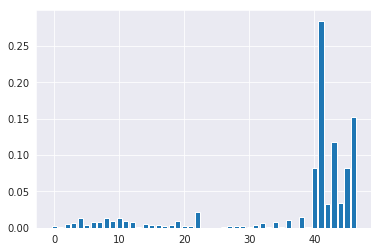

In [585]:
plt.bar(range(len(grad.feature_importances_)),grad.feature_importances_)

In [586]:
np.sort(grad.feature_importances_)

array([0.00000000e+00, 1.86234254e-04, 2.58975665e-04, 2.73325811e-04,
       4.38037273e-04, 8.15382925e-04, 1.19510749e-03, 1.42937106e-03,
       1.49701712e-03, 1.56528790e-03, 1.56570850e-03, 1.84500438e-03,
       2.20790244e-03, 2.24380352e-03, 2.25561024e-03, 2.47070520e-03,
       2.79092192e-03, 3.04330122e-03, 3.48880390e-03, 3.65483472e-03,
       3.72067505e-03, 4.14431768e-03, 4.36444574e-03, 4.87931661e-03,
       5.00897224e-03, 5.91757474e-03, 6.55346580e-03, 7.43932780e-03,
       7.63948432e-03, 7.94390553e-03, 8.36310572e-03, 8.73399972e-03,
       9.12552379e-03, 9.25004847e-03, 1.03036856e-02, 1.36223487e-02,
       1.39251355e-02, 1.39362704e-02, 1.42298777e-02, 2.20461486e-02,
       3.22945585e-02, 3.41383378e-02, 8.15826542e-02, 8.19759261e-02,
       1.18352364e-01, 1.52471481e-01, 2.84811712e-01])

In [588]:
threshold=np.sort(grad.feature_importances_)[1]
test_score=[]
train_score=[]

    # Selecting Features from threshold
selection=SelectFromModel(grad,threshold=threshold,prefit=True)
select_x_train=selection.transform(x_train)
select_x_test=selection.transform(x_test)
select_test=selection.transform(test)
select_train=selection.transform(train_copy)
    # Training Model
grad_select=GradientBoostingRegressor(alpha=0.7,init=xg,
                               n_estimators=300,
                               max_features='auto',learning_rate=0.1,subsample=0.85)
grad_select.fit(select_x_train,y_train)
    
test_score=np.sqrt(mean_squared_log_error(np.exp(y_test.values),np.exp(grad_select.predict(select_x_test))))
train_score=np.sqrt(mean_squared_log_error(np.exp(y_train.values),np.exp(grad_select.predict(select_x_train))))

(test_score,train_score,cross_validation(grad_select,select_x_train,y_train)[1],
np.sqrt(mean_squared_error(np.exp(y_test.values),np.exp(grad_select.predict(select_x_test)))),
np.sqrt(mean_squared_log_error(np.exp(y),np.exp(grad_select.predict(select_train)))))
#plt.bar(range(len(threshold)),[test_score,train_score,cross_score]

(0.16617175700945674,
 0.05943859847898036,
 0.00010752373218035132,
 3.9564724782370084,
 0.08454564076212046)

In [569]:
(mean_squared_error(np.exp(y_test.values),np.exp(grad_select.predict(select_x_test))))

16.27312791101739

In [508]:
np.sqrt(mean_squared_log_error(np.exp(y),np.exp(grad_select.predict(select_train))))

0.08376584051353075

In [598]:
np.exp(grad.predict(test.values))

array([ 2.97162538,  2.96402358, 22.12211568, ...,  2.8817474 ,
        4.80465644, 19.94494557])

In [600]:
submission=pd.DataFrame({'Price':np.exp(grad.predict(test))})
submission.to_excel('submission_grad.xlsx',index=False)

# Using Deep Learning

In [233]:
sequential=Sequential()

# Input Layer
sequential.add(Dense(128,kernel_initializer='normal',input_dim=train_copy.shape[1],activation='relu'))
# Hidden Layer
sequential.add(Dense(100,kernel_initializer='uniform',activation='relu'))

sequential.add(Dense(100,kernel_initializer='normal',activation='relu'))

# Output Layer
sequential.add(Dense(1,kernel_initializer='normal',activation='relu'))
sequential.compile(loss='mean_squared_error',optimizer='adam')

In [1446]:
#sequential.fit(x_train,y_train,batch_size=30,epochs=100)

In [235]:
np.sqrt(mean_squared_log_error(np.exp(y_test),np.exp(sequential.predict(x_test))))

0.16481700058884163

In [236]:
np.sqrt(mean_squared_log_error(np.exp(y_train),np.exp(sequential.predict(x_train))))

0.11561521330211405

# Linear Regression

In [1559]:
lin=LinearRegression()
lin.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1560]:
np.sqrt(mean_squared_log_error(np.exp(y_test),np.exp(lin.predict(x_test))))

0.22146876644195526

In [1561]:
np.sqrt(mean_squared_log_error(np.exp(y_train),np.exp(lin.predict(x_train))))

0.22968196350926479

In [1562]:
np.sqrt(mean_squared_log_error(np.exp(y),np.exp(lin.predict(train_copy))))

0.22846847076354423

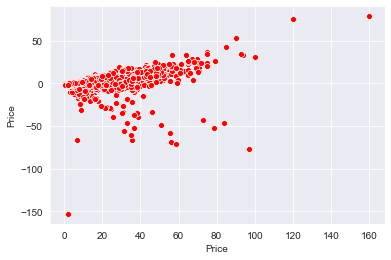

In [1563]:
sns.scatterplot(np.exp(y),np.exp(y)-np.exp(lin.predict(train_copy)),color='red')

In [1564]:
np.exp(lin.predict(test))

array([ 2.65684465,  1.60122033, 16.44036312, ...,  2.73070145,
        4.39189869, 21.40198586])

In [1444]:
submission=pd.DataFrame({'Price':np.exp(lin.predict(test))})
submission.to_excel('submission_lin.xlsx',index=False)